In [1]:
%matplotlib notebook
# %matplotlib inline

import scipy.io as sio

import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
import quantities as pq


from ripple_detection import Karlsson_ripple_detector, Kay_ripple_detector
from ripple_detection.simulate import simulate_time
import scipy.stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def read_out_arrays(data):
    lfp = data['lfp'][0][0]
#     run_speed = np.append(data['run_speed'][0][0].flatten(), 0)
    run_speed = data['run_speed'][0][0].flatten()
    ripple_loc = data['rippleLocs'][0][0].flatten()
    
    return lfp, run_speed, ripple_loc

In [3]:
data = sio.loadmat('../data/m4000series_LFP_ripple.mat')

In [4]:
lfp, run_speed, ripple_loc = read_out_arrays(data['m4015_session2'])
lfp, run_speed, ripple_loc = read_out_arrays(data['m4017_session3'])
lfp, run_speed, ripple_loc = read_out_arrays(data['m4019_session1'])
lfp, run_speed, ripple_loc = read_out_arrays(data['m4020_session2'])
lfp, run_speed, ripple_loc = read_out_arrays(data['m4021_session1'])

In [5]:
SAMPLING_FREQUENCY = 2.5e3
n_samples = lfp.shape[0]
time = simulate_time(n_samples, SAMPLING_FREQUENCY)
speed = np.ones_like(time)


In [6]:
Karlsson_ripple_times = Karlsson_ripple_detector(time, lfp, speed, SAMPLING_FREQUENCY)
Kay_ripple_times = Kay_ripple_detector(time, lfp, speed, SAMPLING_FREQUENCY)

In [7]:
#remove periods of moving:

def remove_when_moving(detector, threashold=0.1):
    delete_mask = np.zeros(detector.shape[0], dtype=bool)
    for i, ripple in enumerate(detector.itertuples()):
        mask = (np.logical_and(ripple.start_time<=time, ripple.end_time>=time))
        delete_mask[i] = np.max(run_speed[mask])<0.1       
    return detector[delete_mask]

Karlsson_ripple_times = remove_when_moving(Karlsson_ripple_times, )
Kay_ripple_times = remove_when_moving(Kay_ripple_times, )

<IPython.core.display.Javascript object>


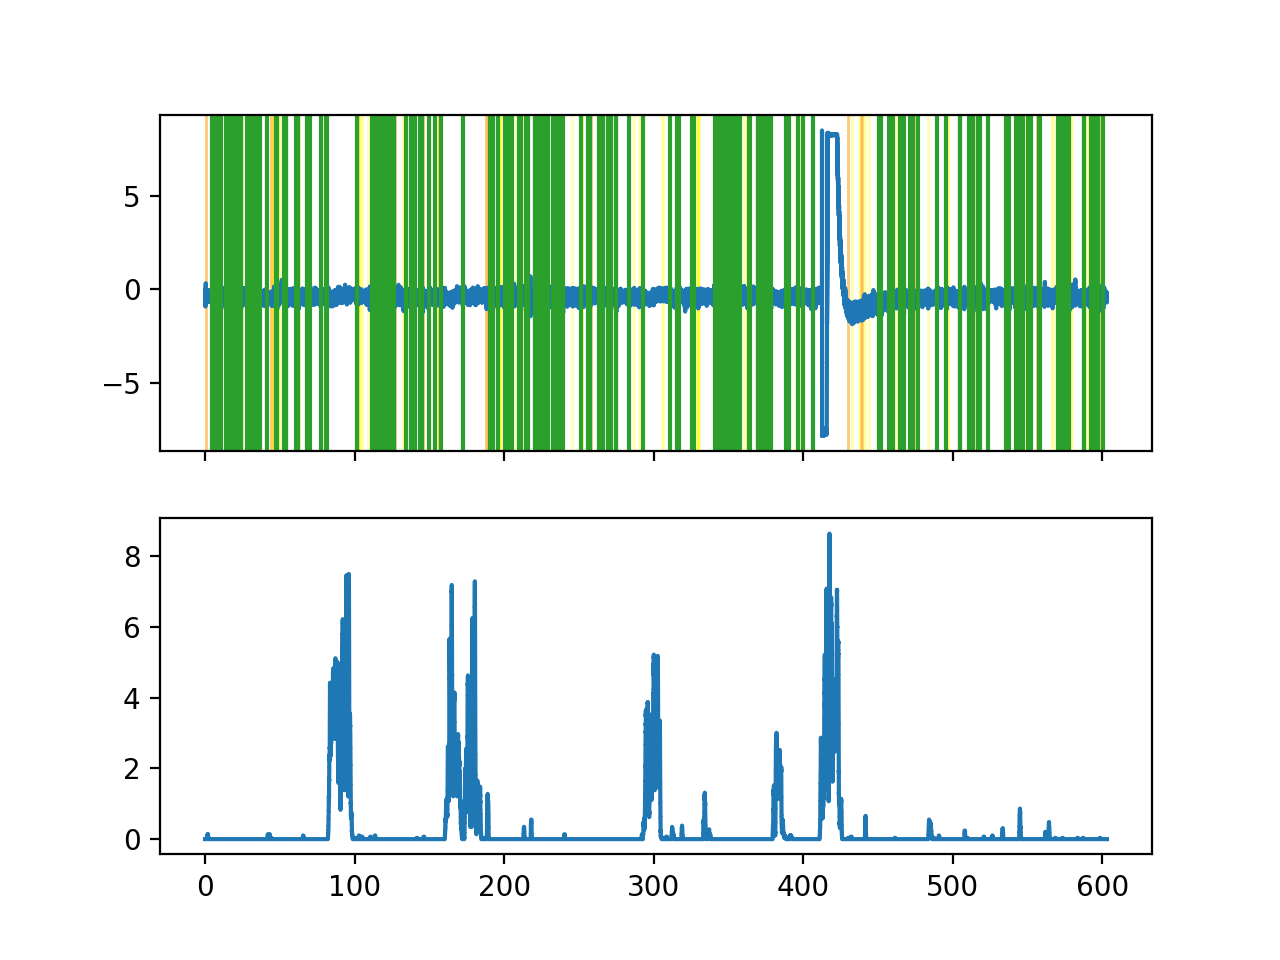

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(time, lfp)
for ripple in Karlsson_ripple_times.itertuples():
    ax1.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=0)
for ripple in Kay_ripple_times.itertuples():
    ax1.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='yellow', zorder=0) 
for ripple in ripple_loc:
    ax1.axvline(time[ripple], color='C2')
ax2.plot(time, run_speed)
f.show()

In [9]:
ripples = time[ripple_loc]

def point_covered_in_period(points, periods):
    start = periods['start_time'].values
    end = periods['end_time'].values
    counts = np.zeros_like(points)
    for i in range(len(points)):
        for j in range(len(start)):
            if np.logical_and(start[j]<=points[i], end[j]>=points[i]):
                counts[i] = 1
    return np.sum(counts)/len(counts)



def period_overlapping_point(points, periods):
    start = periods['start_time'].values
    end = periods['end_time'].values
    counts = np.zeros_like(start)
    for j in range(len(start)):
        for i in range(len(points)):
            if np.logical_and(start[j]<=points[i], end[j]>=points[i]):
                counts[j] = 1
    return np.sum(counts)/len(counts)


def period_overlapping_period(periods1, periods2):
    start1 = periods1['start_time'].values
    end1 = periods1['end_time'].values
    start2 = periods2['start_time'].values
    end2 = periods2['end_time'].values
    counts = np.zeros_like(start1)
    for i in range(len(start1)):
        for j in range(len(start2)):
            if np.logical_and(start2[j]<=start1[i], end2[j]>=start1[i]):
                counts[i] = 1
            if np.logical_and(start2[j]<=end1[i], end2[j]>=end1[i]):
                counts[i] = 1
            if np.logical_and(start2[j]>=start1[i], end2[j]<=end1[i]):
                counts[i] = 1
    return np.sum(counts)/len(counts)





res = np.eye(3)
res[0,1] = point_covered_in_period(ripples, Karlsson_ripple_times)
res[0,2] = point_covered_in_period(ripples, Kay_ripple_times)
res[1,0] = period_overlapping_point(ripples, Karlsson_ripple_times)
res[1,2] = period_overlapping_period(Kay_ripple_times, Karlsson_ripple_times)
res[2,0] =  period_overlapping_point(ripples, Kay_ripple_times)
res[2,1] = period_overlapping_period(Karlsson_ripple_times, Kay_ripple_times)

<IPython.core.display.Javascript object>


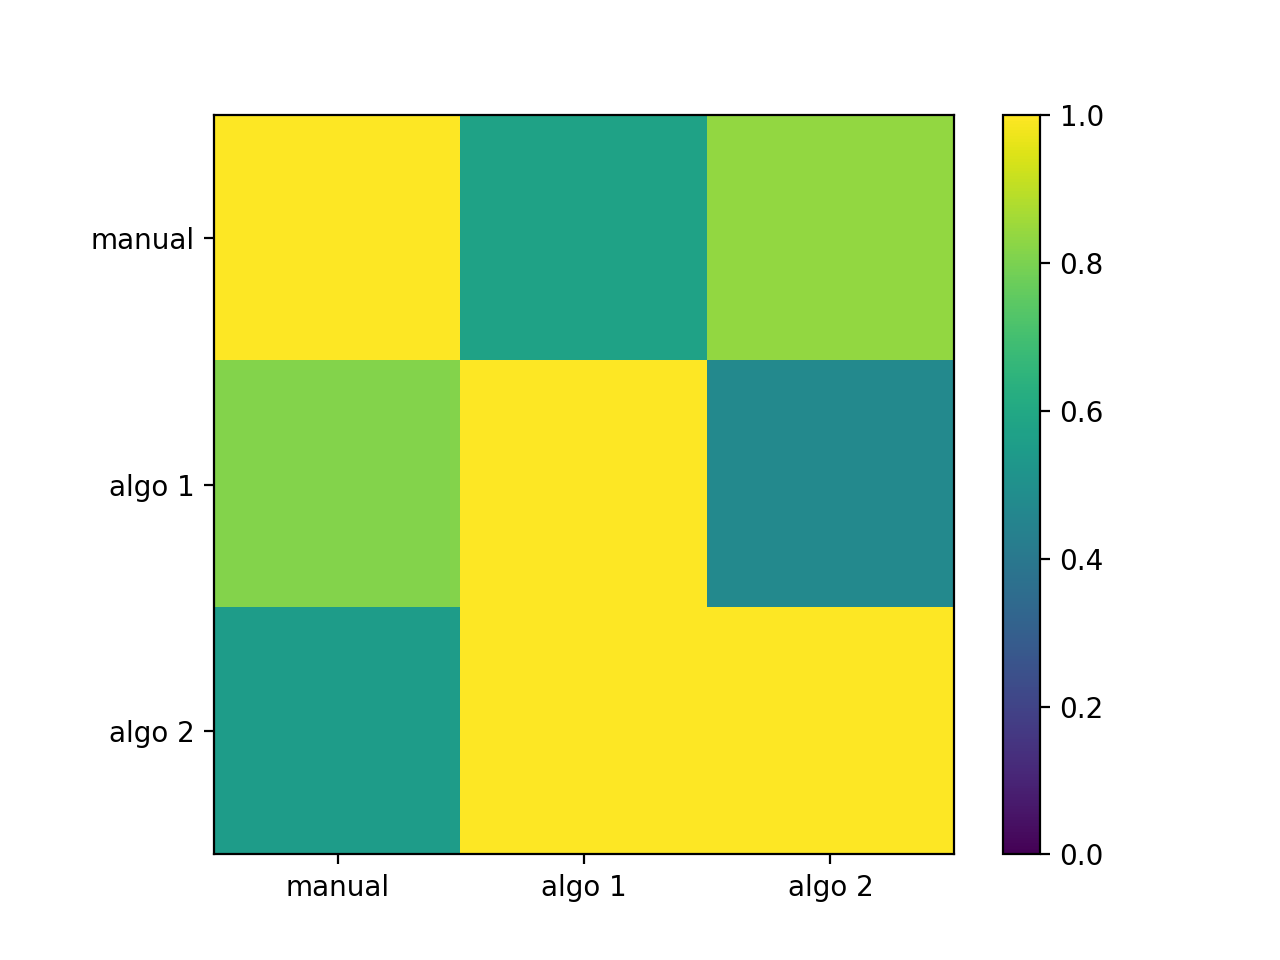

In [10]:
true = ["manual", "algo 1", "algo 2"]
test = ["manual", "algo 1", "algo 2"]


fig, ax = plt.subplots()
im = ax.imshow(res, vmin=0, vmax=1)
ax.set_xticks(np.arange(len(true)))
ax.set_yticks(np.arange(len(test)))
ax.set_xticklabels(true)
ax.set_yticklabels(test)
ax.figure.colorbar(im)
fig.savefig('plots/m4021.pdf')

In [11]:
# for i, ripple in enumerate(Karlsson_ripple_times.itertuples()):
#     f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
#     ax1.plot(time, LFPs)
#     ax1.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=0)
#     ax1.set_xlim(ripple.start_time-0.2, ripple.end_time+0.1)
    
#     for ripple2 in Kay_ripple_times.itertuples():
#         ax1.axvspan(ripple2.start_time, ripple2.end_time, alpha=0.3, color='yellow', zorder=0)
#     for ripple_true in ripple_loc:
#         ax1.axvline(time[ripple_true], color='C2')
        
#     ax2.plot(time[:-1], run_info)
    
#     path = os.path.join('..', 'plots', 'algo_1', str(i)+'.pdf')
#     f.savefig(path)
#     plt.close()
    
    
# for i, ripple in enumerate(Kay_ripple_times.itertuples()):
#     f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
#     ax1.plot(time, LFPs)
#     ax1.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='yellow', zorder=0)
#     ax1.set_xlim(ripple.start_time-0.2, ripple.end_time+0.1)
    
#     for ripple2 in Karlsson_ripple_times.itertuples():
#         ax1.axvspan(ripple2.start_time, ripple2.end_time, alpha=0.3, color='red', zorder=0)
#     for ripple_true in ripple_loc:
#         ax1.axvline(time[ripple_true], color='C2')
        
#     ax2.plot(time[:-1], run_info)
    
#     path = os.path.join('..', 'plots', 'algo_2', str(i)+'.pdf')
#     f.savefig(path)
#     plt.close()
    
    
# for i, ripple in enumerate(ripple_loc):
#     f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
#     ax1.plot(time, LFPs)
#     ax1.axvline(time[ripple], color='C2')
#     ax1.set_xlim(time[ripple]-0.3, time[ripple]+0.2)
    
#     for ripple2 in Karlsson_ripple_times.itertuples():
#         ax1.axvspan(ripple2.start_time, ripple2.end_time, alpha=0.3, color='red', zorder=0)
#     for ripple2 in Kay_ripple_times.itertuples():
#         ax1.axvspan(ripple2.start_time, ripple2.end_time, alpha=0.3, color='yellow', zorder=0)
        
#     ax2.plot(time[:-1], run_info)
    
#     path = os.path.join('..', 'plots', 'algo_anna', str(i)+'.pdf')
#     f.savefig(path)
#     plt.close()